# Section II. Feature Engineering

### Load libraries, functions, palette, theme

In [1]:
import os
from pathlib import Path

In [2]:
# load functions
from __functions import *

In [3]:
# load libraries and palette
%run __libraries.ipynb

In [4]:
# start stopwatch
start = stopwatch_start()

### Variables

In [5]:
dir_current = '02-feature-engineering'

In [6]:
dir_load_files = 'files/'

In [7]:
dir_save_files = 'files/'

In [8]:
dir_save_img = 'docs/img/'

### Load Files

##### Dictionaries

In [9]:
datasets = loadit('datasets', dir=dir_load_files)

##### Datasets

In [10]:
train = extract_variable('train_raw', datasets)

In [11]:
valid = extract_variable('valid_raw', datasets)

In [12]:
test = extract_variable('test_raw', datasets)

## Feature Engineering

In [13]:
train.head(3)

,temperature,humidity,windspeed,generaldiffuseflows,diffuseflows,target,target2,target3,minute,hour,...,weekday,week,month,year_month,year_day,count_elmnts_by_day,target_diff,target_returns,target_volatility,p
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,0,0,...,6,52,1,2017-01,2017-01-01,1,NaN,NaN,NaN,NaN
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,10,0,...,6,52,1,2017-01,2017-01-01,2,-4241.01266,-12.453167,0.015508,-0.124532
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,20,0,...,6,52,1,2017-01,2017-01-01,3,-686.58227,-2.302833,0.000530,-0.023028


#### Minute of day

In [14]:
%%time
for i in train['day_of_year']:
    leng_i = len(train[train['day_of_year']==i])
    values_ = arange(0, leng_i*10, 10)
    train.loc[train['day_of_year']==i, 'minute_of_day'] = values_

CPU times: user 43.8 s, sys: 978 ms, total: 44.8 s
Wall time: 49.4 s


In [15]:
%%time
for i in valid['day_of_year']:
    leng_i = len(valid[valid['day_of_year']==i])
    values_ = arange(0, leng_i*10, 10)
    valid.loc[valid['day_of_year']==i, 'minute_of_day'] = values_

CPU times: user 5.73 s, sys: 114 ms, total: 5.84 s
Wall time: 6.17 s


In [16]:
train['minute_of_day']

2017-01-01 00:00:00       0.0
2017-01-01 00:10:00      10.0
2017-01-01 00:20:00      20.0
2017-01-01 00:30:00      30.0
2017-01-01 00:40:00      40.0
                        ...  
2017-07-31 23:10:00    1390.0
2017-07-31 23:20:00    1400.0
2017-07-31 23:30:00    1410.0
2017-07-31 23:40:00    1420.0
2017-07-31 23:50:00    1430.0
Freq: 10min, Name: minute_of_day, Length: 30528, dtype: float64

In [17]:
valid['minute_of_day']

2017-08-01 00:00:00       0.0
2017-08-01 00:10:00      10.0
2017-08-01 00:20:00      20.0
2017-08-01 00:30:00      30.0
2017-08-01 00:40:00      40.0
                        ...  
2017-08-31 23:10:00    1390.0
2017-08-31 23:20:00    1400.0
2017-08-31 23:30:00    1410.0
2017-08-31 23:40:00    1420.0
2017-08-31 23:50:00    1430.0
Freq: 10min, Name: minute_of_day, Length: 4464, dtype: float64

<Axes: xlabel='minute_of_day', ylabel='target'>

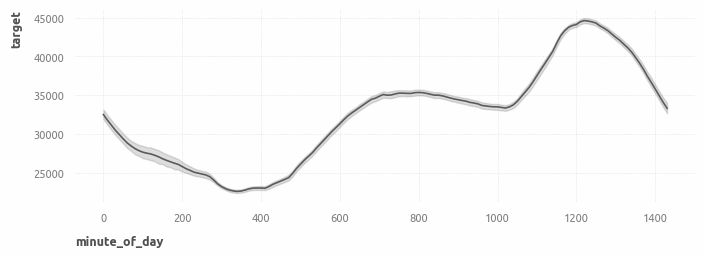

In [18]:
sns.lineplot(
    data=train,
    x='minute_of_day',
    y='target'
)

#### Features 'is_Friday' and 'is_Sunday'

In [19]:
train['is_Friday'] = (train['weekday']==4).astype(int)

In [20]:
train['is_Sunday'] = (train['weekday']==6).astype(int)

In [21]:
valid['is_Friday'] = (valid['weekday']==4).astype(int)

In [22]:
valid['is_Sunday'] = (valid['weekday']==6).astype(int)

#### Feature 'diff_Sunday'

If Sunday:  
- 'diff_Sunday' == difference between mean of target value during ordinary days and mean of target value during sundays for previous month

else:  
- 0

In [23]:
train = generate_feature_diff_sunday(train, 'target')

In [24]:
train_nos = train.loc['2017-07'].loc[train['weekday'] != 6].copy()

In [25]:
train_s = train.loc['2017-07'].loc[train['weekday'] == 6].copy()

In [26]:
diff_Sunday_valid = \
    train_nos.groupby(['hour', 'minute']).mean()['target'] \
    - train_s.groupby(['hour', 'minute']).mean()['target']

In [27]:
valid['diff_Sunday'] = np.NaN

In [28]:
valid_s_number = int(len(valid[valid['weekday']==6]) / 144)        

In [29]:
diff_Sunday_valid = list(diff_Sunday_valid) * valid_s_number

In [30]:
valid.loc[valid['weekday'] == 6, 'diff_Sunday'] = diff_Sunday_valid

In [31]:
valid['diff_Sunday'] = valid['diff_Sunday'].fillna(0)

#### Features 'is_Day'

In [32]:
train['is_Day'] = ((5 < train['hour']) & (train['hour'] < 21)).astype(int)

In [33]:
valid['is_Day'] = ((5 < valid['hour']) & (valid['hour'] < 21)).astype(int)

#### Feature 'is_31'

In [34]:
train['is_31'] = (train['day']==31).astype(int)

In [35]:
valid['is_31'] = (valid['day']==31).astype(int)

#### Feature 'is_20hours'

In [36]:
train['is_20hours'] = (train['hour']==19).astype(int)

In [37]:
valid['is_20hours'] = (valid['hour']==19).astype(int)

#### Cumulative average of Target

In [38]:
train['target_cum_avg'] = \
    (train.groupby('day_of_year')['target'].cumsum().values
     / train['count_elmnts_by_day'].values)

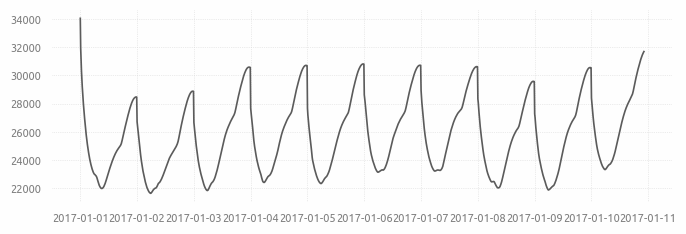

In [39]:
plt.plot(train['target_cum_avg'][:143*10]);

In [40]:
train['target_cum_avg'] = train['target_cum_avg'].shift(1)

In [41]:
train[['target', 'target_cum_avg']]

,target,target_cum_avg
2017-01-01 00:00:00,34055.69620,NaN
2017-01-01 00:10:00,29814.68354,34055.696200
2017-01-01 00:20:00,29128.10127,31935.189870
2017-01-01 00:30:00,28228.86076,30999.493670
2017-01-01 00:40:00,27335.69620,30306.835442
...,...,...
2017-07-31 23:10:00,43407.30897,38477.324984
2017-07-31 23:20:00,42507.90698,38512.539156
2017-07-31 23:30:00,41659.53488,38540.875098
2017-07-31 23:40:00,40843.05648,38562.837490


In [42]:
scipy.stats.pearsonr(
    train['target_cum_avg'][1:],
    train['target'][1:]
)

PearsonRResult(statistic=0.5919214986544622, pvalue=0.0)

In [43]:
scipy.stats.pearsonr(
    train['target_cum_avg'].shift()[2:],
    train['target_cum_avg'][2:]
)

PearsonRResult(statistic=0.997255936836215, pvalue=0.0)

#### Value in previous month

Value of 'target' from previous month minute-by-minute

In [44]:
train['target_previous_month'] = generate_feature_previous_month(train, 'target')

In [45]:
train['target_previous_month']

2017-01-01 00:00:00            NaN
2017-01-01 00:10:00            NaN
2017-01-01 00:20:00            NaN
2017-01-01 00:30:00            NaN
2017-01-01 00:40:00            NaN
                          ...     
2017-07-31 23:10:00    40205.56291
2017-07-31 23:20:00    39423.57616
2017-07-31 23:30:00    38883.17881
2017-07-31 23:40:00    38107.54967
2017-07-31 23:50:00    37312.84768
Freq: 10min, Name: target_previous_month, Length: 30528, dtype: float64

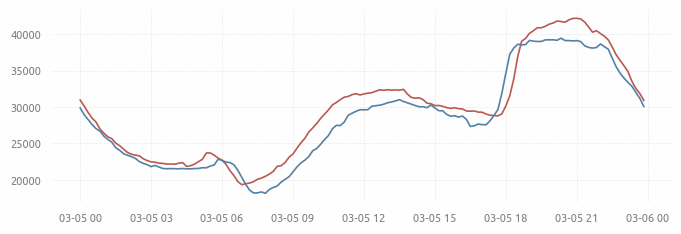

In [46]:
plt.plot(train.loc['2017-03-05', 'target'], color=palette[1])
plt.plot(train.loc['2017-03-05', 'target_previous_month'], color=palette[2])

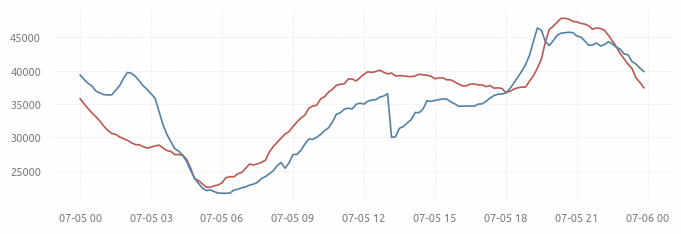

In [47]:
plt.plot(train.loc['2017-07-05', 'target'], color=palette[1])
plt.plot(train.loc['2017-07-05', 'target_previous_month'], color=palette[2])

In [48]:
valid['target_previous_month'] = train.loc['2017-07-01':, 'target'].values

## Save Data

In [49]:
datasets['train_preprocessed'] = train

In [50]:
datasets['valid_preprocessed'] = valid

In [51]:
saveit(datasets, 'datasets', dir_save_files)

File 'datasets.pkl' saved in directory 'files/'


### Execution time

In [52]:
stopwatch_stop(start)

Execution time: 0:01:04
